Instalación de dependencias y carga de librerías

Instala y carga todas las librerías necesarias: NLTK, spaCy, TextBlob, pandas, seaborn, etc.

Para preparar el entorno de trabajo con herramientas que permiten procesar texto, calcular métricas lingüísticas y visualizarlas. Es la base técnica del análisis.

In [1]:
# ==============================
# 📦 1. Instalación de dependencias
# ==============================

# Solo si no están instaladas:
%pip install PyPDF2 nltk textblob seaborn matplotlib pandas scikit-learn pycryptodome

import os
import re
import nltk
import PyPDF2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from textblob import TextBlob

nltk.download('punkt')
nltk.download('stopwords')
import textblob.download_corpora
textblob.download_corpora.download_all()


stop_words = set(stopwords.words('spanish'))



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\angel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\angel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\angel\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\angel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\angel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\angel\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Dow

# Análisis de Frecuencia por Categoría Gramatical (POS)

Objetivo: Extraer y visualizar las 20 palabras más frecuentes por tipo gramatical: sustantivos, verbos y adjetivos, agrupados por nivel escolar.

Justificación metodológica: Este análisis permite caracterizar el estilo y foco lingüístico de los textos por nivel. Por ejemplo, textos con muchos verbos de acción pueden estar más orientados al dinamismo, mientras que muchos sustantivos abstractos pueden implicar mayor complejidad conceptual.

analizar_pos_normalizado_por_nivel() usa spaCy para:
- Identificar sustantivos, verbos y adjetivos.
- Normalizar frecuencia por 100 palabras.
- Visualizar los 20 más frecuentes por nivel.

Para identificar cómo cambia el estilo lingüístico entre niveles: más verbos en niveles bajos, más sustantivos abstractos en niveles altos, por ejemplo.

In [2]:
import spacy
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

nlp = spacy.load("es_core_news_sm")

def analizar_pos_normalizado_por_nivel(df_results, escala=100):
    """
    Analiza las 20 palabras más frecuentes por categoría gramatical, normalizadas por longitud.
    Muestra 3 gráficos por nivel en una sola fila: NOUN, VERB, ADJ.
    """
    niveles = df_results["Nivel"].unique()

    for nivel in niveles:
        textos = df_results[df_results["Nivel"] == nivel]["TextoLimpio"]
        texto_unido = " ".join(textos)
        doc = nlp(texto_unido)

        tokens_filtrados = [token for token in doc if token.is_alpha and not token.is_stop]
        total_tokens = len(tokens_filtrados)

        def extraer_normalizados_por_pos(pos_tag):
            palabras = [token.text.lower() for token in tokens_filtrados if token.pos_ == pos_tag]
            conteo = Counter(palabras)
            normalizado = {k: (v / total_tokens) * escala for k, v in conteo.items()}
            return dict(sorted(normalizado.items(), key=lambda x: x[1], reverse=True)[:20])

        categorias = [("NOUN", "steelblue"), ("VERB", "seagreen"), ("ADJ", "darkorange")]

        # Crear figura con 3 subplots en una fila
        fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

        for idx, (categoria, color) in enumerate(categorias):
            frec_norm = extraer_normalizados_por_pos(categoria)
            palabras, tasas = zip(*frec_norm.items())

            sns.barplot(x=list(palabras), y=list(tasas), color=color, ax=axes[idx])
            axes[idx].set_title(f"{nivel} - {categoria}")
            axes[idx].set_ylabel("Frecuencia Normalizada")
            axes[idx].tick_params(axis='x', rotation=45)

        fig.suptitle(f"Nivel: {nivel} - Top 20 palabras por categoría gramatical (normalizado por {escala} palabras)", fontsize=14)
        fig.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


# Normalización de Métricas por Longitud (sin POS)

Objetivo: Evitar que los libros más extensos dominen las métricas. Se calcula frecuencia o sentimiento por 100 palabras o por oración, para tener medidas comparables entre textos de distinta extensión.

Justificación metodológica: Como en el estudio de Pichintún (tesis ekatherina), la normalización evita sesgos por longitud textual, crucial para mi análisis de progresión entre niveles escolares.

Frecuencia Normalizada = (N° de apariciones de la palabra / Total de palabras del corpus​) × 100 Palbras (o puede ser 1000)

Esto porque los libros varían mucho en longitud. Si no normalizo, las palabras de libros más largos dominarán los resultados aunque no sean realmente más frecuentes proporcionalmente. Con frecuencia normalizada, puedo comparar proporcionalmente entre niveles o libros, sin sesgos por longitud textual.

----------------------------------------------------------------------------------
Ejemplo:

Palabra	|Eje Y (Frecuencia por 100 palabras)

"niño"   	|12.3

"casa"	    |9.8

Por cada 100 palabras, aparece "niño" 12.3 veces, "casa" 9.8 veces, etc.

In [3]:
# Frecuencia normalizada por escala (por defecto 100 palabras)
def frecuencia_normalizada(palabras, total_palabras, escala=100):
    conteo = Counter(palabras)
    return {k: (v / total_palabras) * escala for k, v in conteo.items()}

# Sentimiento promedio por oración
def sentimiento_normalizado(texto):
    oraciones = sent_tokenize(texto, language="spanish")
    polaridades = [TextBlob(oracion).sentiment.polarity for oracion in oraciones]
    return np.mean(polaridades) if polaridades else 0


top_palabras_normalizadas_por_nivel() calcula y grafica las palabras más frecuentes (sin POS), también normalizadas por longitud.


Para descubrir vocabulario clave o temas centrales en cada nivel escolar, facilitando comparaciones léxicas.

In [4]:
# Análisis de frecuencia normalizada de palabras por nivel escolar
def top_palabras_normalizadas_por_nivel(df_results, escala=100, top_n=20):
    niveles = sorted(df_results["Nivel"].unique())

    for nivel in niveles:
        textos = df_results[df_results["Nivel"] == nivel]["TextoLimpio"]
        texto_unido = " ".join(textos)

        palabras = word_tokenize(texto_unido.lower(), language="spanish")
        palabras = [w for w in palabras if w.isalpha()]  # solo letras
        total = len(palabras)
        if total == 0:
            print(f"Nivel {nivel} vacío o sin palabras válidas.")
            continue

        frec_norm = frecuencia_normalizada(palabras, total, escala)
        frec_ordenadas = dict(sorted(frec_norm.items(), key=lambda x: x[1], reverse=True)[:top_n])

        palabras_top, valores_top = zip(*frec_ordenadas.items())
        plt.figure(figsize=(8, 3))
        sns.barplot(x=list(palabras_top), y=list(valores_top), color="skyblue")
        plt.title(f"{nivel} - Top {top_n} palabras (por {escala} palabras)")
        plt.ylabel("Frecuencia normalizada")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


Define la función clean_text_preservando_espanol() que:

    - Pasa el texto a minúsculas.
    - Elimina signos no alfabéticos.
    - Filtra stopwords y verbos narrativos frecuentes (como "dijo", "preguntó").

Esto para evitar que palabras comunes sin valor semántico (muletillas narrativas o artículos) distorsionen los análisis de frecuencia y complejidad.

In [5]:
def clean_text_preservando_espanol(texto):
    import re
    from nltk.tokenize import word_tokenize
    # Lista de palabras a excluir además de las stopwords
    verbos_narrativos_comunes = {"dijo", "preguntó", "respondió", "exclamó", "gritó", "comentó"}
    texto = texto.lower()
    # Elimina guiones largos y similares
    texto = re.sub(r'[\u2013\u2014\u2015]', ' ', texto)
    # Elimina palabras de una sola letra
    texto = re.sub(r'\b\w\b', '', texto)
    # Elimina números
    texto = re.sub(r'\d+', '', texto)
    # Elimina caracteres no alfabéticos excepto espacios y letras con tildes
    texto = re.sub(r"[^a-záéíóúüñ\s]", "", texto)
    # Tokeniza y filtra
    tokens = word_tokenize(texto, language="spanish")
    tokens_filtrados = [
        token for token in tokens
        if token not in stop_words and token not in verbos_narrativos_comunes
    ]
    return " ".join(tokens_filtrados)


In [6]:
def extract_text_from_pdf(pdf_path):
    with open(pdf_path, "rb") as f:
        reader = PyPDF2.PdfReader(f)
        return "\n".join([page.extract_text() for page in reader.pages if page.extract_text()])

def lexical_diversity(text):
    words = word_tokenize(text)
    unique_words = set(words)
    return len(unique_words) / len(words) if words else 0

def avg_word_length(text):
    words = word_tokenize(text)
    lengths = [len(w) for w in words if w.isalpha()]
    return np.mean(lengths) if lengths else 0

def avg_sentence_length(text):
    sentences = sent_tokenize(text, language="spanish")
    lengths = [len(word_tokenize(s)) for s in sentences]
    return np.mean(lengths) if lengths else 0

def sentiment_by_sentence(text):
    oraciones = sent_tokenize(text, language='spanish')
    polaridades = [TextBlob(o).sentiment.polarity for o in oraciones]
    return np.mean(polaridades) if polaridades else 0


Con analyze_books_by_level() se extraen:

    - Diversidad léxica.
    - Largo promedio de palabra.
    - Largo promedio de oración.
    - Sentimiento promedio.
Estas métricas permiten cuantificar la complejidad de los textos y observar su progresión a través de los niveles escolares.

In [7]:

def analyze_books_by_level(book_paths_with_levels):
    resultados = []

    for nivel, pdf_path in book_paths_with_levels:
        try:
            texto = extract_text_from_pdf(pdf_path)
            texto_limpio = clean_text_preservando_espanol(texto)

            resultados.append({
                "Nivel": nivel,
                "Libro": os.path.basename(pdf_path),
                "TextoLimpio": texto_limpio,
                "DiversidadLexica": lexical_diversity(texto_limpio),
                "LargoPromPalabra": avg_word_length(texto_limpio),
                "LargoPromOracion": avg_sentence_length(texto),
                "SentimientoPromedio": sentiment_by_sentence(texto),
            })

        except Exception as e:
            print(f"Error con {pdf_path}: {e}")

    return pd.DataFrame(resultados)


boxplot_complejidad(): Para ver tendencias, dispersión y valores atípicos en las métricas lingüísticas por nivel escolar

In [8]:
def boxplot_complejidad(df, variable="LargoPromPalabra"):
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x="Nivel", y=variable, palette="coolwarm")
    plt.title(f"Boxplot de {variable} por Nivel Escolar")
    plt.ylabel(variable)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [9]:
import glob
import os

def cargar_libros_por_nivel(directorio_base='./Libros'):
    """
    Recorre las carpetas organizadas por nivel (1Basico, 2Basico, ..., 4Medio)
    y devuelve una lista de tuplas (nivel, ruta_pdf).
    """
    niveles_dict = {
        "1Basico": "1º Básico", "2Basico": "2º Básico", "3Basico": "3º Básico", "4Basico": "4º Básico"
    }

    pdf_paths_with_levels = []

    for carpeta, nombre_nivel in niveles_dict.items():
        carpeta_path = os.path.join(directorio_base, carpeta)
        if os.path.exists(carpeta_path):
            pdfs = glob.glob(os.path.join(carpeta_path, "*.pdf"))
            for ruta_pdf in pdfs:
                pdf_paths_with_levels.append((nombre_nivel, ruta_pdf))
        else:
            print(f"Carpeta no encontrada: {carpeta_path}")

    return pdf_paths_with_levels


In [10]:
# Ejecutar análisis
pdf_paths_with_levels = cargar_libros_por_nivel()  # si usas carpetas
df_results = analyze_books_by_level(pdf_paths_with_levels)

Carpeta no encontrada: ./Libros\4Basico


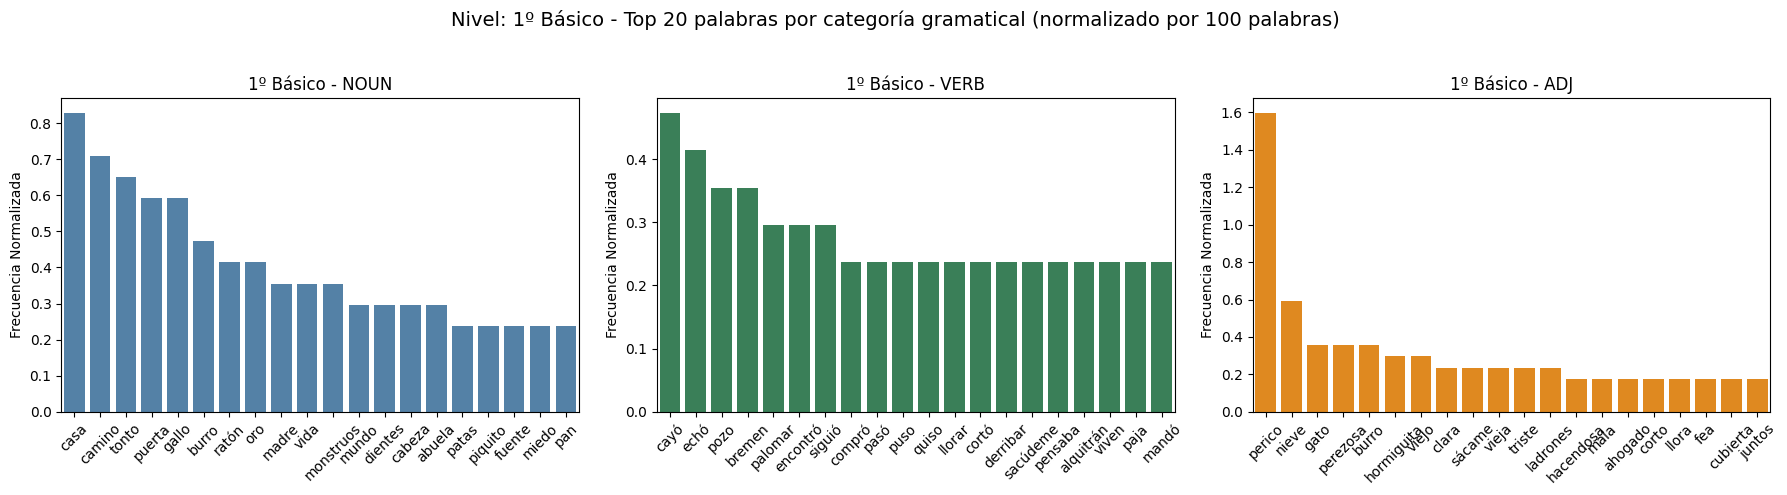

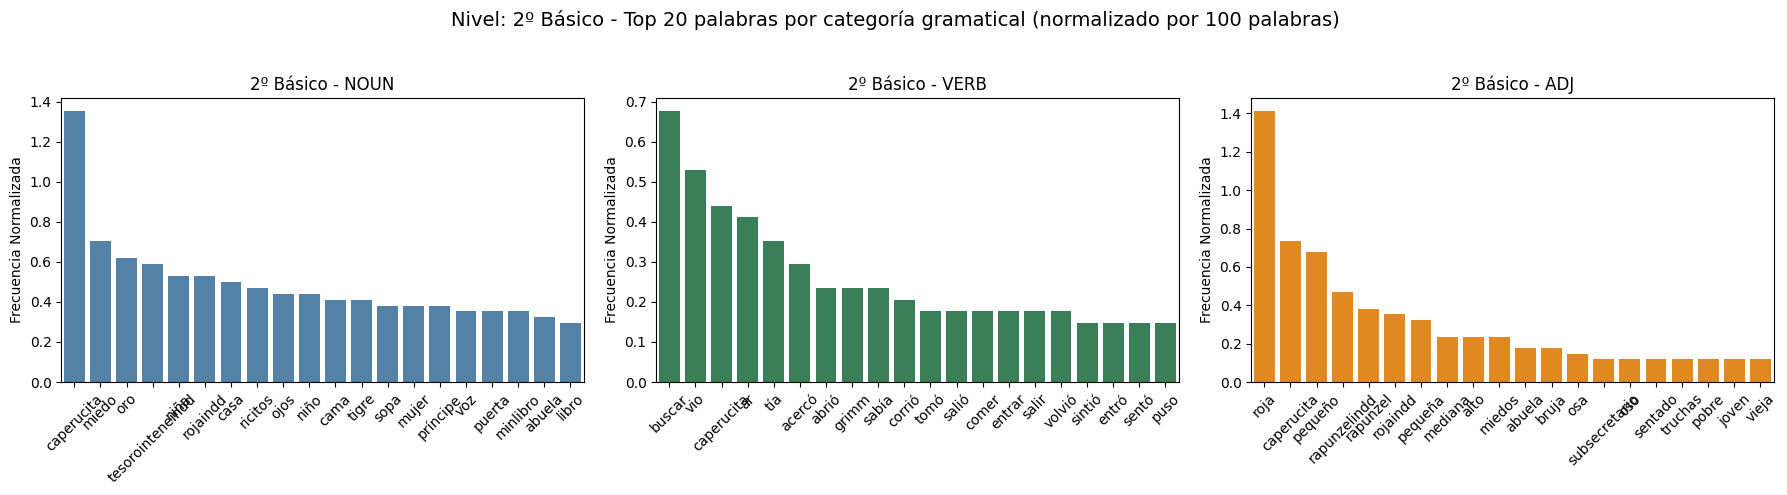

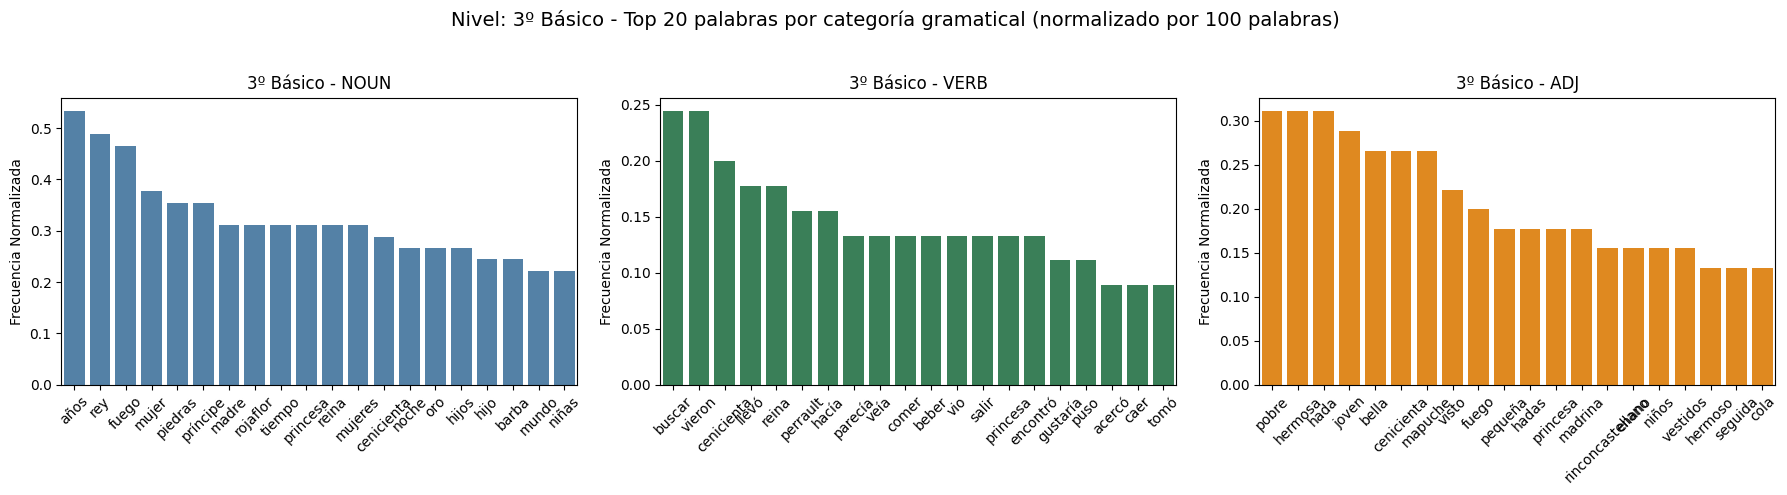

In [11]:
# Ejecutar Análisis de Frecuencia por Categoría Gramatical (POS)
analizar_pos_normalizado_por_nivel(df_results, escala=100)

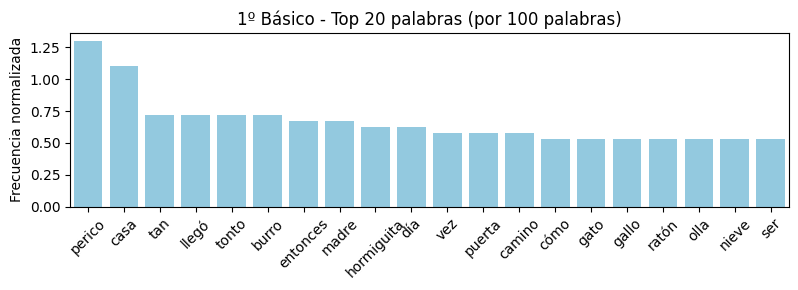

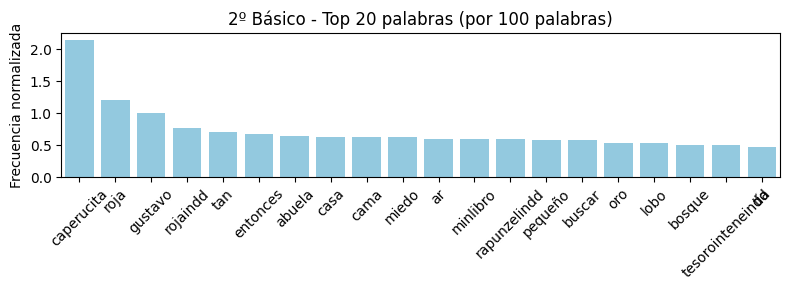

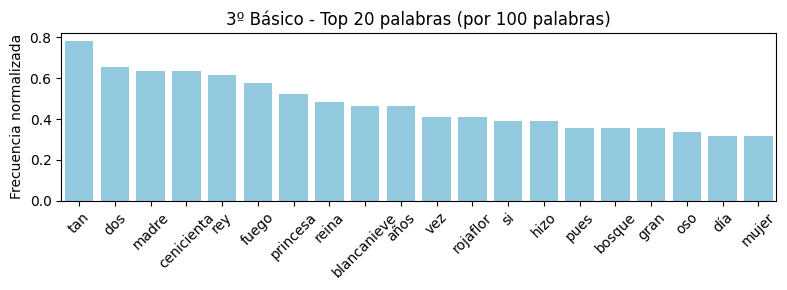

In [12]:
# Análisis de frecuencia normalizada de palabras por nivel escolar
top_palabras_normalizadas_por_nivel(df_results)

,Nivel,Libro,TextoLimpio,DiversidadLexica,LargoPromPalabra,LargoPromOracion,SentimientoPromedio
0,1º Básico,articles-22419_recurso_pdf.pdf,hormiguita fernán caballero abía vez hormiguit...,0.573883,5.879725,18.534884,0.000000
1,1º Básico,articles-23632_recurso_pdf.pdf,madre nieve hermanos grimm na viuda dos hijas ...,0.604839,5.899194,20.413793,0.000000
2,1º Básico,Donde viven los monstruos-Maurice Sendak.pdf,viven monstruos maurice sendak noche max puso ...,0.652174,6.192547,33.333333,0.000000
3,1º Básico,El-tonto-Perico.pdf,saber contar contar saber pan queso pa tontos ...,0.606407,5.718535,11.376344,0.002151
4,1º Básico,LOS-MUSICOS-DE-BREMEN.pdf,wwwotsieracom músicos bremen hermanos grimm ér...,0.667626,6.469065,20.530864,-0.012346
5,2º Básico,84523f-voces-prim-ricitos-de-oro.pdf,ricitos oro voces yer oy ricitos oro voces yer...,0.539514,6.306991,16.457831,0.005120
6,2º Básico,buscar-un-tesoro-int-pdf_1.pdf,historia cómo osito pequeño tigre buscan mayor...,0.620000,6.362857,12.305556,0.006944
7,2º Básico,caperucita.pdf,lust ado diego moscato caperucita rojah libro ...,0.526316,6.297530,19.304000,0.000000
8,2º Básico,eld_rapunzel-_lm2020_ma.pdf,jardín fascinante prohibido mujer espera niño ...,0.526119,6.339552,19.479167,0.000000
9,2º Básico,LIBR-NIV127102021154653.pdf,gustavo miedos ricardo alcantara miedos aparec...,0.608730,6.153968,13.209821,-0.005357


C:\Users\angel\AppData\Local\Temp\ipykernel_12884\3767521539.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Nivel", y=variable, palette="coolwarm")


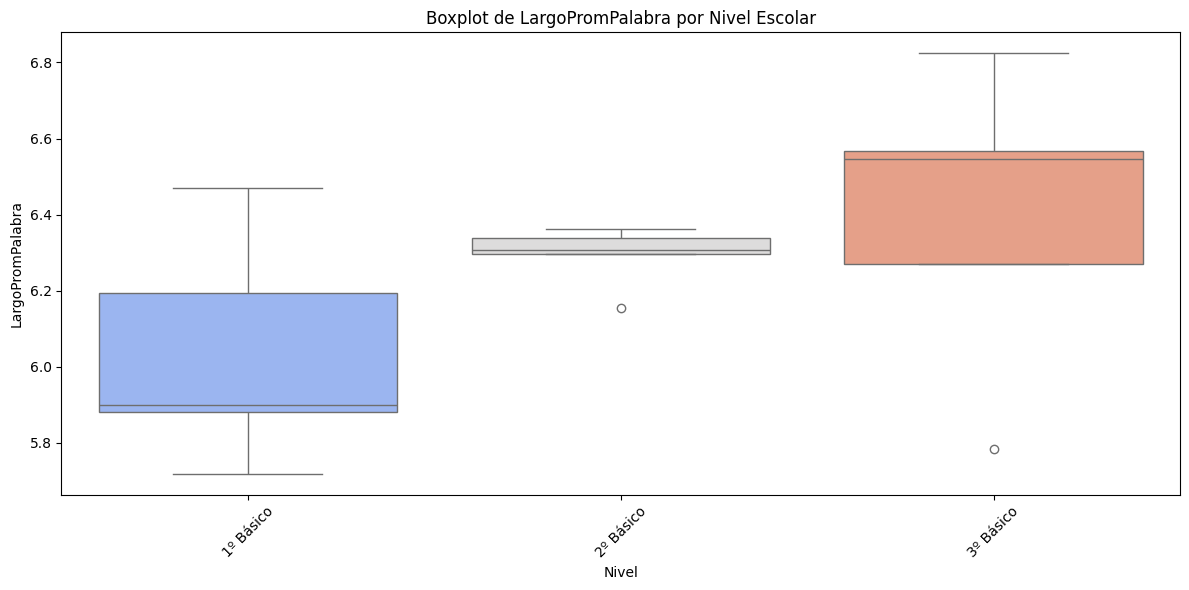

C:\Users\angel\AppData\Local\Temp\ipykernel_12884\3767521539.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Nivel", y=variable, palette="coolwarm")


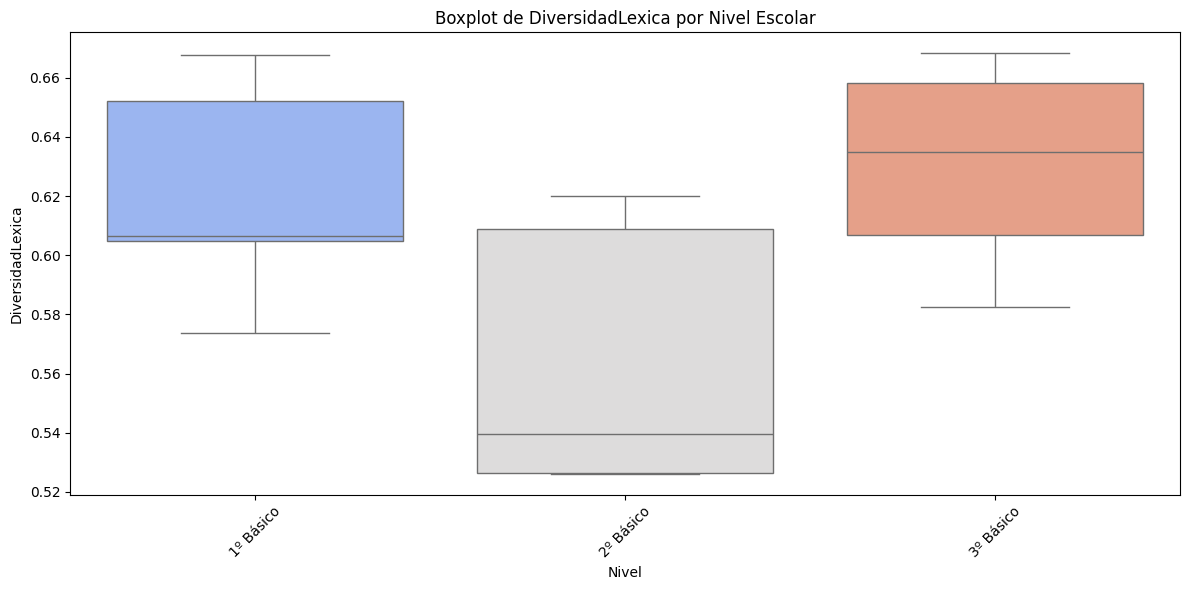

C:\Users\angel\AppData\Local\Temp\ipykernel_12884\3767521539.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Nivel", y=variable, palette="coolwarm")


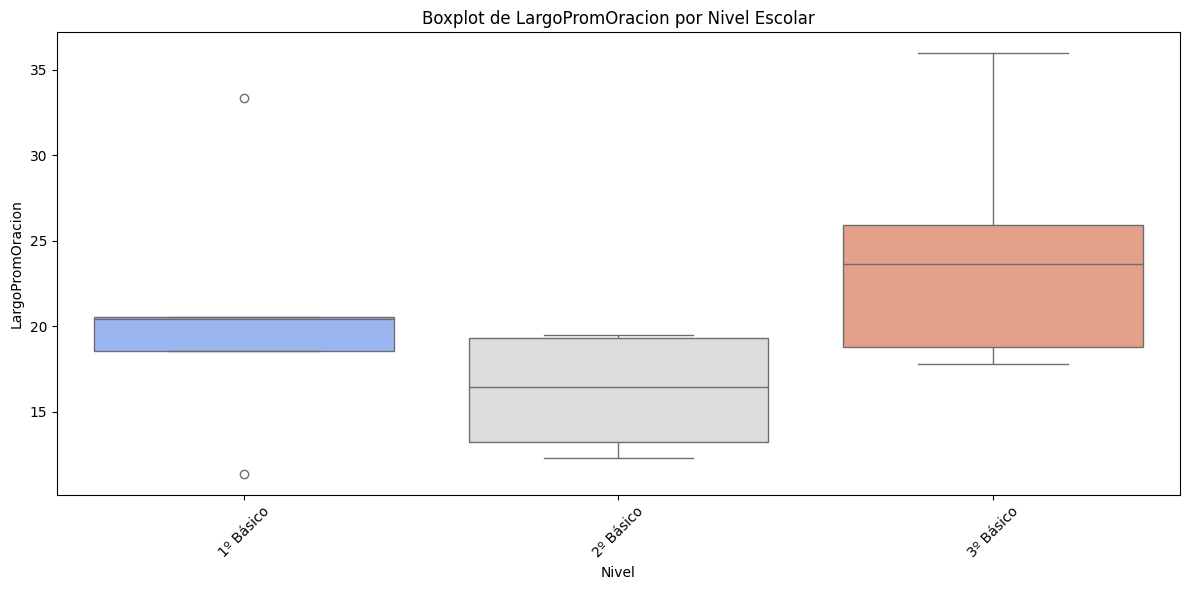

In [13]:
# Ver resultados
display(df_results)

# Boxplots
boxplot_complejidad(df_results, variable="LargoPromPalabra")
boxplot_complejidad(df_results, variable="DiversidadLexica")
boxplot_complejidad(df_results, variable="LargoPromOracion")


In [14]:
# Paso previo: asegurarte de tener estas librerías
%pip install scikit-posthocs

import pandas as pd
import numpy as np
from scipy.stats import kruskal
import scikit_posthocs as sp
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import seaborn as sns


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


calcular_métricas_resumen() promedia las métricas de cada libro para obtener valores globales por nivel.

-Para poder comparar niveles como unidades analíticas y aplicar análisis estadísticos y de clustering.

- Agrupa todos los libros del mismo nivel, ya que, hay libros de distintas longitudes.
- Une sus textos (TextoLimpio).

- A partir del texto combinado, calcula una nueva métrica global:

    Largo promedio de palabra: sobre todas las palabras de todos los libros de ese nivel.

    Diversidad léxica: sobre el total de palabras únicas dividido por total de palabras.

    Sentimiento promedio: sobre todas las oraciones del corpus unido.

In [15]:
def calcular_métricas_resumen(df_results):
    resumen = []
    niveles = df_results["Nivel"].unique()
    for nivel in niveles:
        textos = df_results[df_results["Nivel"] == nivel]["TextoLimpio"]
        texto_unido = " ".join(textos)

        palabras = nltk.word_tokenize(texto_unido, language="spanish")
        oraciones = nltk.sent_tokenize(texto_unido, language="spanish")

        total_palabras = len(palabras)
        total_oraciones = len(oraciones)
        largo_prom_palabra = np.mean([len(w) for w in palabras if w.isalpha()]) if palabras else 0
        diversidad_lexica = len(set(palabras)) / len(palabras) if palabras else 0

        polaridades = [TextBlob(o).sentiment.polarity for o in oraciones]
        sentimiento_prom = np.mean(polaridades) if polaridades else 0

        resumen.append({
            "Nivel": nivel,
            "Palabras Totales": total_palabras,
            "Oraciones Totales": total_oraciones,
            "LargoPromPalabra": largo_prom_palabra,
            "DiversidadLexica": diversidad_lexica,
            "SentimientoPromedio": sentimiento_prom
        })

    return pd.DataFrame(resumen).sort_values("Nivel")

In [16]:
df_resumen = calcular_métricas_resumen(df_results)

In [17]:
print(df_resumen.columns)


Index(['Nivel', 'Palabras Totales', 'Oraciones Totales', 'LargoPromPalabra',
       'DiversidadLexica', 'SentimientoPromedio'],
      dtype='object')


Agrupa los niveles escolares según sus métricas lingüísticas utilizando ward linkage.

- Para ver si los niveles se agrupan naturalmente en etapas de complejidad similar (por ejemplo, básica vs. media).

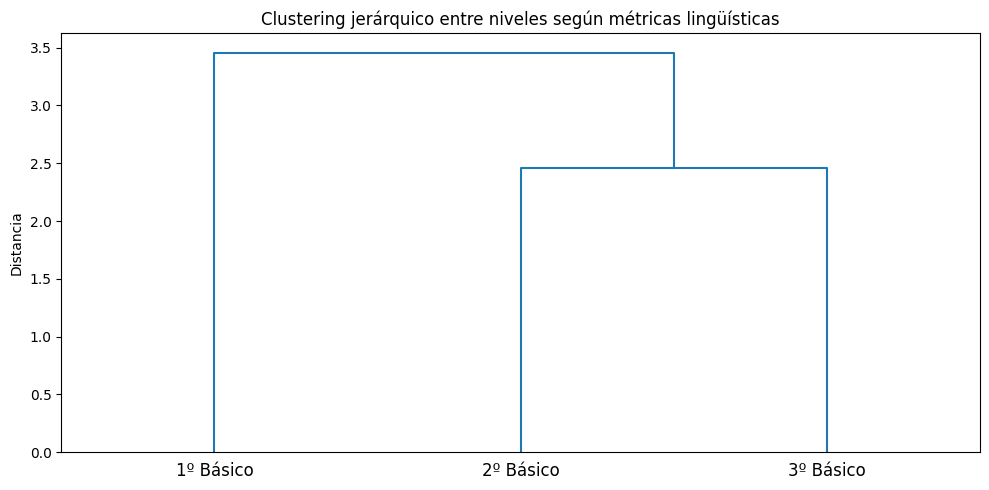

In [18]:
# Clustering jerárquico por nivel
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage

metricas_estadisticas = ["LargoPromPalabra", "DiversidadLexica", "SentimientoPromedio"]
datos_cluster = df_resumen.set_index("Nivel")[metricas_estadisticas]
datos_norm = StandardScaler().fit_transform(datos_cluster)

plt.figure(figsize=(10, 5))
linked = linkage(datos_norm, method="ward")
dendrogram(linked, labels=datos_cluster.index, orientation="top")
plt.title("Clustering jerárquico entre niveles según métricas lingüísticas")
plt.ylabel("Distancia")
plt.tight_layout()
plt.show()


In [19]:
# Verificando el contenido de la columna 'Nivel' en ambos DataFrames
df_results['Nivel'].head(), df_resumen['Nivel'].head()


(0    1º Básico
 1    1º Básico
 2    1º Básico
 3    1º Básico
 4    1º Básico
 Name: Nivel, dtype: object,
 0    1º Básico
 1    2º Básico
 2    3º Básico
 Name: Nivel, dtype: object)

# Aplicación de la prueba de Kruskal-Wallis por métrica.

Ejecutar post-hoc Dunn si hay diferencias significativas

- **Aplica la prueba de Kruskal-Wallis por métrica donde compara más de dos grupos independientes para ver si al menos uno de ellos difiere significativamente en la distribución de una variable:** Esta prueba no paramétrica es adecuada en contextos donde no se puede asumir normalidad ni igualdad de varianzas, como ocurre comúnmente en análisis de textos con muestras pequeñas o moderadas. **RESPONDE: ¿Existe alguna diferencia entre los niveles?**

SI se detecta una diferencia, entonces se:

- **Ejecuta post-hoc de Dunn con corrección de Holm si hay diferencias significativas:** para contrastes múltiples cuando se detectaron diferencias globales. **RESPONDE: ¿Qué pares específicos de niveles se diferencian?**

Para evaluar si las diferencias entre niveles son estadísticamente significativas, respaldando mis conclusiones con:
- Nivel de significancia (α) = 0.05
- Nivel de confianza = 95%

Si el p-valor < 0.05, se rechaza la hipótesis nula, es decir, se concluye que hay diferencias significativas entre al menos dos grupos.

Si el p-valor ≥ 0.05, no se rechaza la hipótesis nula: no se encontraron diferencias estadísticamente significativas con 95% de confianza.

Elección porque:

- Estás comparando 3 o más grupos independientes (niveles escolares).

- Tus métricas no garantizan seguir una distribución normal (y probablemente no lo hagan).

- Tienes muestras de tamaño moderado por grupo (~10 libros).

- No asumes varianzas iguales entre niveles.

In [20]:
from scipy.stats import kruskal
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import seaborn as sns

# Asegurar tipo string para 'Nivel'
df_results["Nivel"] = df_results["Nivel"].astype(str)

# Métricas a comparar entre niveles
metricas_estadisticas = ["LargoPromPalabra", "DiversidadLexica", "SentimientoPromedio"]

kruskal_results = {}
posthoc_results = {}

for metrica in metricas_estadisticas:
    grupos = [grupo[metrica].values for name, grupo in df_results.groupby("Nivel")]

    if all(len(g) > 1 for g in grupos):  # Verifica que todos los grupos tengan al menos 2 elementos
        h_stat, p_val = kruskal(*grupos)
        kruskal_results[metrica] = {"H": h_stat, "p": p_val}

        if p_val < 0.05:
            posthoc = sp.posthoc_dunn(df_results, val_col=metrica, group_col="Nivel", p_adjust="holm")
            posthoc_results[metrica] = posthoc

# Mostrar resultados
print("Resultados Kruskal-Wallis:")
for metrica, resultado in kruskal_results.items():
    print(f"{metrica}: H={resultado['H']:.2f}, p={resultado['p']:.4f}")


Resultados Kruskal-Wallis:
LargoPromPalabra: H=3.26, p=0.1959
DiversidadLexica: H=3.78, p=0.1511
SentimientoPromedio: H=2.02, p=0.3646


In [21]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# df_results["Nivel"] = df_results["Nivel"].astype(str)
# metricas_estadisticas = ["LargoPromPalabra", "DiversidadLexica", "SentimientoPromedio"]

# for metrica in metricas_estadisticas:
#     plt.figure(figsize=(10, 5))
#     sns.boxplot(data=df_results, x="Nivel", y=metrica)
#     plt.title(f"Distribución de {metrica} por Nivel Escolar")
#     plt.xlabel("Nivel Escolar")
#     plt.ylabel(metrica)
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.show()


Integración de Análisis de Nubes de Palabras y N-gramas

Como complemento al análisis cuantitativo de métricas lingüísticas tradicionales (como la longitud promedio de palabra, diversidad léxica y sentimiento promedio), se incorporaron técnicas de exploración visual y semántica como las nubes de palabras y el análisis de n-gramas (bigramas y trigramas). 

- plot_wordcloud_by_level() muestra nubes por nivel.
- plot_ngrams_by_level() muestra los bigramas y trigramas más comunes.

Para visualizar de forma visual los patrones léxicos y temáticos, al estilo del análisis aplicado en el estudio de Darwin. (profe manu)

In [22]:
# Preparamos un esquema base para aplicar técnicas inspiradas en el análisis del texto de Darwin
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk import bigrams, trigrams
from collections import Counter
import seaborn as sns

# Función para generar una nube de palabras por nivel escolar
def plot_wordcloud_by_level(df_results):
    niveles = df_results["Nivel"].unique()
    for nivel in niveles:
        textos = df_results[df_results["Nivel"] == nivel]["TextoLimpio"]
        texto = " ".join(textos)
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"Nube de Palabras - Nivel: {nivel}")
        plt.show()

# Función para mostrar bigramas y trigramas más comunes por nivel
def plot_ngrams_by_level(df_results, tipo='bigram', top_n=10):
    niveles = df_results["Nivel"].unique()
    for nivel in niveles:
        textos = df_results[df_results["Nivel"] == nivel]["TextoLimpio"]
        tokens = " ".join(textos).split()
        if tipo == 'bigram':
            ngram_list = list(bigrams(tokens))
        elif tipo == 'trigram':
            ngram_list = list(trigrams(tokens))
        else:
            continue
        ngram_freq = Counter(ngram_list).most_common(top_n)
        ngrams_labels = [' '.join(ng) for ng, _ in ngram_freq]
        ngrams_values = [v for _, v in ngram_freq]

        plt.figure(figsize=(10, 4))
        sns.barplot(x=ngrams_labels, y=ngrams_values)
        plt.xticks(rotation=45)
        plt.title(f"{tipo.capitalize()}s más comunes - Nivel: {nivel}")
        plt.ylabel("Frecuencia")
        plt.tight_layout()
        plt.show()



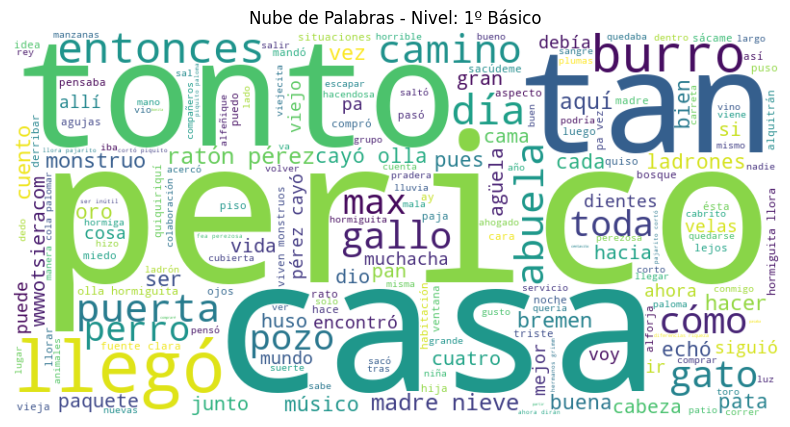

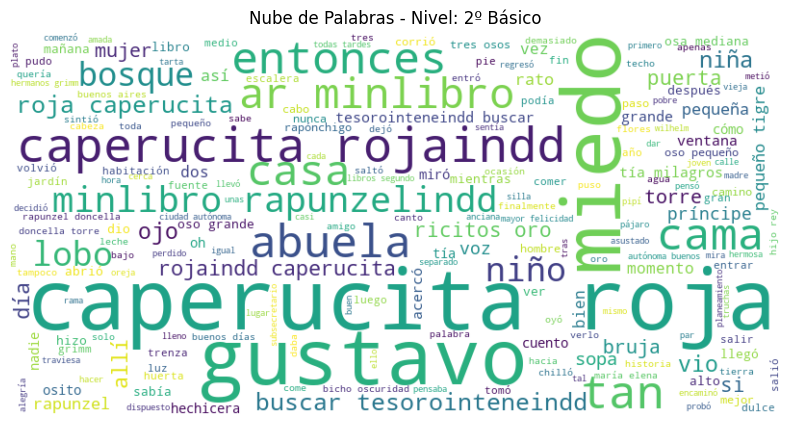

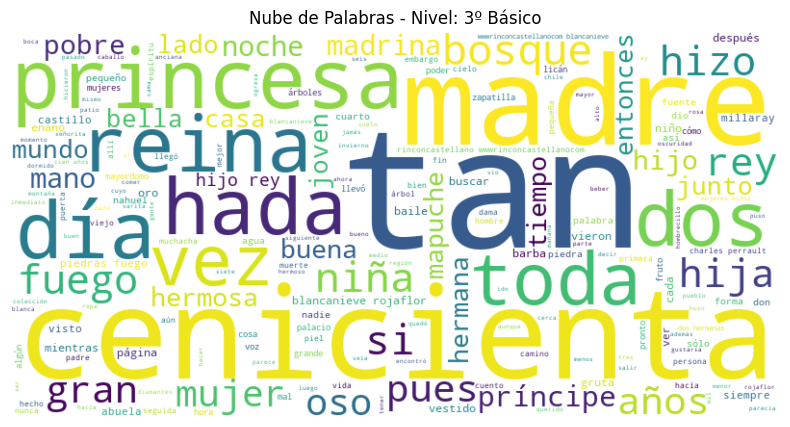

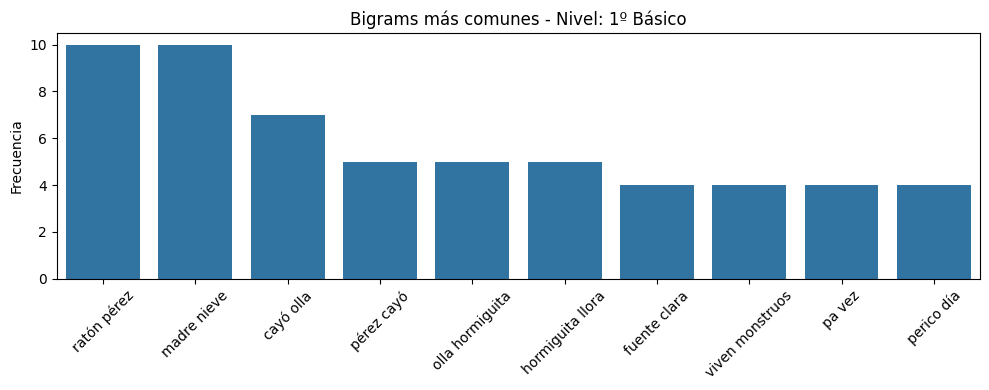

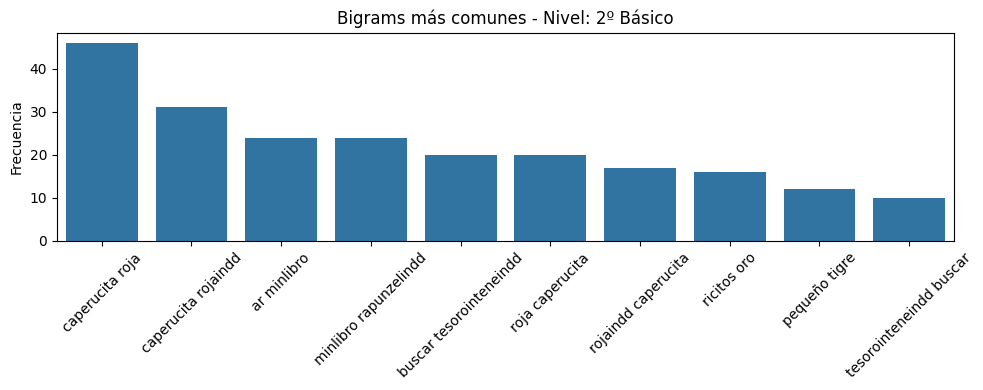

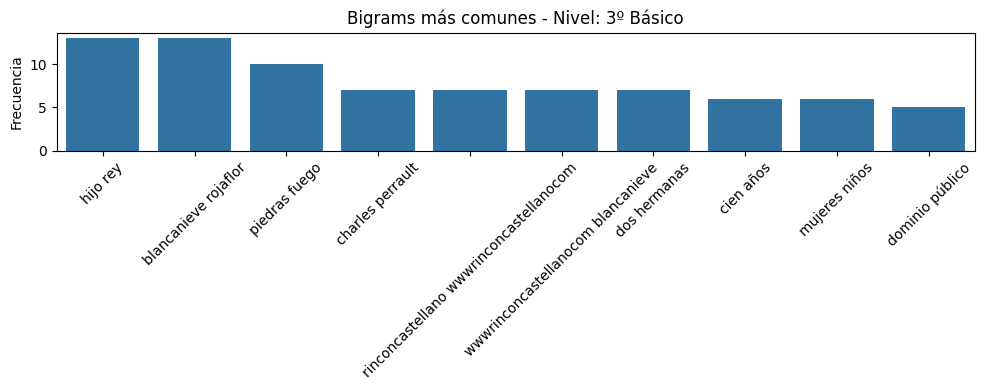

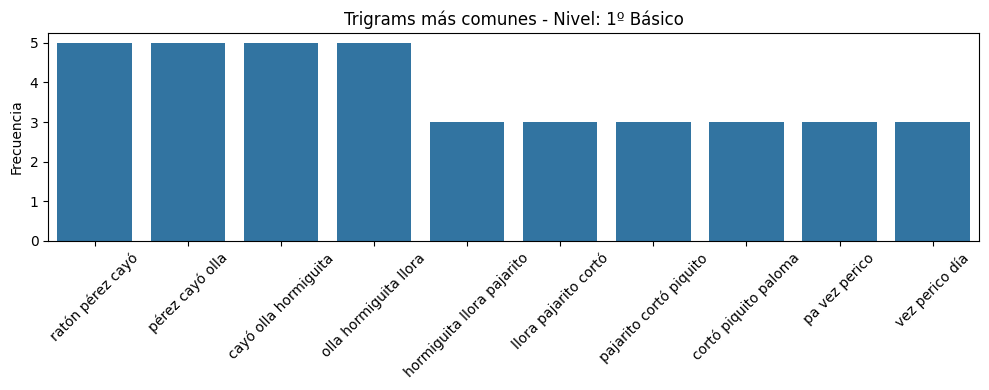

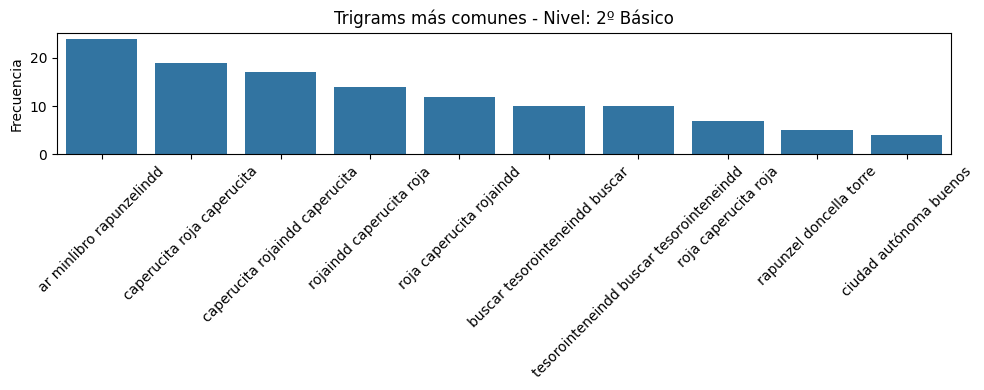

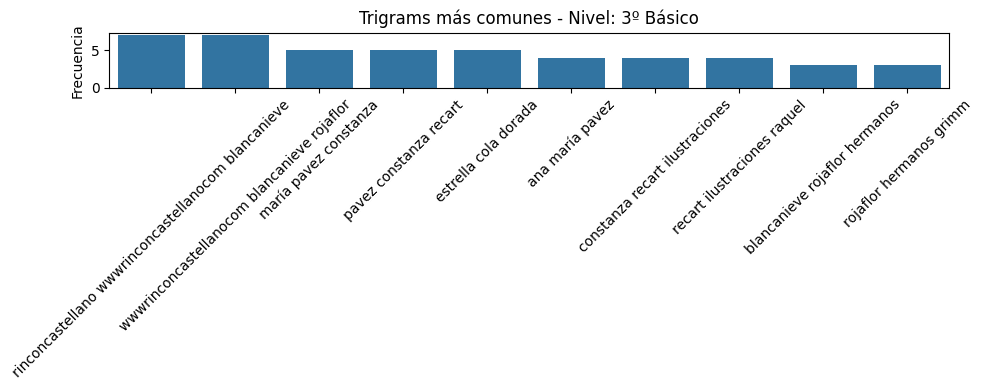

In [23]:
# Si el usuario lo desea, puede correr localmente:
plot_wordcloud_by_level(df_results)
plot_ngrams_by_level(df_results, tipo='bigram')
plot_ngrams_by_level(df_results, tipo='trigram')


In [24]:
# Paso 1: Instalar dependencias (solo necesitas ejecutar esto una vez en tu entorno local)
%pip install bertopic[all] --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
# Bloque para análisis de tópicos con BERTopic, usando textos limpios de df_results

# Paso 2: Cargar e instanciar el modelo
from bertopic import BERTopic

# Filtrar textos válidos y su nivel para referencia posterior
documentos = df_results["TextoLimpio"].tolist()
niveles = df_results["Nivel"].tolist()

# Paso 3: Entrenar modelo BERTopic
topic_model = BERTopic(language="multilingual", verbose=True)
topics, probs = topic_model.fit_transform(documentos)

# Paso 4: Mostrar resumen de los temas
info_temas = topic_model.get_topic_info()
display(info_temas)

# Paso 5: Visualización interactiva segura
# Extraer solo temas válidos con tamaño > 0 (excluye el -1 y vacíos)
temas_validos = info_temas[info_temas['Topic'] >= 0]["Topic"].tolist()


# Paso 6: Asignar temas detectados al DataFrame original
df_results["TópicoBERTopic"] = topics

df_results.head()



c:\Users\angel\Documents\Tesis\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-05-12 01:48:53,228 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]
2025-05-12 01:48:58,305 - BERTopic - Embedding - Completed ✓
2025-05-12 01:48:58,306 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-12 01:49:11,200 - BERTopic - Dimensionality - Completed ✓
2025-05-12 01:49:11,203 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-12 01:49:11,212 - BERTopic - Cluster - Completed ✓
2025-05-12 01:49:11,218 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-12 01:49:11,276 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,-1,15,-1_caperucita_tan_casa_entonces,"[caperucita, tan, casa, entonces, madre, roja,...",[recursos dominio público cenicienta charles p...


,Nivel,Libro,TextoLimpio,DiversidadLexica,LargoPromPalabra,LargoPromOracion,SentimientoPromedio,TópicoBERTopic
0,1º Básico,articles-22419_recurso_pdf.pdf,hormiguita fernán caballero abía vez hormiguit...,0.573883,5.879725,18.534884,0.000000,-1
1,1º Básico,articles-23632_recurso_pdf.pdf,madre nieve hermanos grimm na viuda dos hijas ...,0.604839,5.899194,20.413793,0.000000,-1
2,1º Básico,Donde viven los monstruos-Maurice Sendak.pdf,viven monstruos maurice sendak noche max puso ...,0.652174,6.192547,33.333333,0.000000,-1
3,1º Básico,El-tonto-Perico.pdf,saber contar contar saber pan queso pa tontos ...,0.606407,5.718535,11.376344,0.002151,-1
4,1º Básico,LOS-MUSICOS-DE-BREMEN.pdf,wwwotsieracom músicos bremen hermanos grimm ér...,0.667626,6.469065,20.530864,-0.012346,-1


In [26]:
# Bloque para análisis de tópicos con LDA clásico usando Gensim

# 1. Instalar las dependencias necesarias (si no las tienes aún)
%pip install gensim nltk spacy --quiet
!python -m spacy download es_core_news_sm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
     ---- ----------------------------------- 1.6/12.9 MB 10.5 MB/s eta 0:00:02
     --------- ------------------------------ 3.1/12.9 MB 8.0 MB/s eta 0:00:02
     ---------------- ----------------------- 5.2/12.9 MB 8.4 MB/s eta 0:00:01
     -------------------------- ------------- 8.4/12.9 MB 10.0 MB/s eta 0:00:01
     --------------------------------- ----- 11.0/12.9 MB 10.4 MB/s eta 0:00:01
     --------------------------------------- 12.9/12.9 MB 10.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
# Descargar recursos de NLTK si es necesario
nltk.download("punkt")
nltk.download("stopwords")

# Cargar spaCy para lematización en español
nlp = spacy.load("es_core_news_sm")
stop_words = set(stopwords.words("spanish"))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\angel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\angel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
#Usando LDA
# 2. Preprocesamiento: tokenización, lematización y filtrado
import gensim
import gensim.corpora as corpora
from gensim.models import LdaModel
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy

def preprocess(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if token.is_alpha and token.text.lower() not in stop_words]

# Aplicar a todos los textos
textos_preprocesados = df_results["TextoLimpio"].apply(preprocess)

# 3. Crear diccionario y corpus
dictionary = corpora.Dictionary(textos_preprocesados)
corpus = [dictionary.doc2bow(texto) for texto in textos_preprocesados]

# 4. Entrenar modelo LDA
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=5,  # puedes ajustar este número
                     random_state=42,
                     update_every=1,
                     chunksize=100,
                     passes=10,
                     alpha='auto',
                     per_word_topics=True)

# 5. Mostrar los temas
temas_lda = lda_model.print_topics(num_words=10)
for i, tema in enumerate(temas_lda):
    print(f"Tópico {i}:\n{tema}\n")

Tópico 0:
(0, '0.015*"perico" + 0.009*"llegar" + 0.009*"tonto" + 0.008*"madre" + 0.007*"casa" + 0.006*"hacer" + 0.006*"monstruo" + 0.006*"día" + 0.006*"abuela" + 0.006*"ir"')

Tópico 1:
(1, '0.009*"blancanieve" + 0.009*"rapunzelindd" + 0.009*"minlibro" + 0.009*"ar" + 0.008*"rojaflor" + 0.007*"ver" + 0.007*"poder" + 0.007*"oso" + 0.006*"rapunzel" + 0.006*"niña"')

Tópico 2:
(2, '0.015*"gustavo" + 0.015*"miedo" + 0.010*"buscar" + 0.010*"tanto" + 0.008*"tesorointeneindd" + 0.007*"hacer" + 0.006*"niño" + 0.006*"pequeño" + 0.006*"ver" + 0.006*"tigre"')

Tópico 3:
(3, '0.012*"caperucita" + 0.010*"rojo" + 0.009*"hacer" + 0.009*"poder" + 0.007*"tanto" + 0.007*"ver" + 0.006*"rojaindd" + 0.006*"rey" + 0.005*"hijo" + 0.004*"casa"')

Tópico 4:
(4, '0.009*"fuego" + 0.009*"oso" + 0.007*"oro" + 0.007*"pequeño" + 0.006*"ricito" + 0.006*"mujer" + 0.005*"ver" + 0.005*"sopa" + 0.005*"mapuche" + 0.005*"niño"')



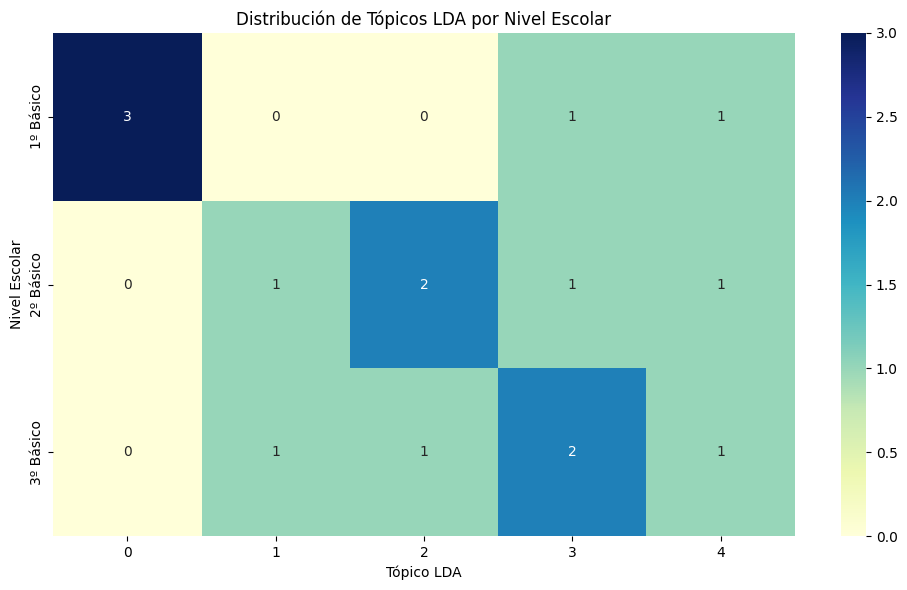

Tópico 0:
(0, '0.015*"perico" + 0.009*"llegar" + 0.009*"tonto" + 0.008*"madre" + 0.007*"casa" + 0.006*"hacer" + 0.006*"monstruo" + 0.006*"día" + 0.006*"abuela" + 0.006*"ir"')

Tópico 1:
(1, '0.009*"blancanieve" + 0.009*"rapunzelindd" + 0.009*"minlibro" + 0.009*"ar" + 0.008*"rojaflor" + 0.007*"ver" + 0.007*"poder" + 0.007*"oso" + 0.006*"rapunzel" + 0.006*"niña"')

Tópico 2:
(2, '0.015*"gustavo" + 0.015*"miedo" + 0.010*"buscar" + 0.010*"tanto" + 0.008*"tesorointeneindd" + 0.007*"hacer" + 0.006*"niño" + 0.006*"pequeño" + 0.006*"ver" + 0.006*"tigre"')

Tópico 3:
(3, '0.012*"caperucita" + 0.010*"rojo" + 0.009*"hacer" + 0.009*"poder" + 0.007*"tanto" + 0.007*"ver" + 0.006*"rojaindd" + 0.006*"rey" + 0.005*"hijo" + 0.004*"casa"')

Tópico 4:
(4, '0.009*"fuego" + 0.009*"oso" + 0.007*"oro" + 0.007*"pequeño" + 0.006*"ricito" + 0.006*"mujer" + 0.005*"ver" + 0.005*"sopa" + 0.005*"mapuche" + 0.005*"niño"')



In [29]:
# Paso 6: Asignar tópico más probable a cada documento
document_topics = [lda_model.get_document_topics(doc) for doc in corpus]

# Extraer solo el tópico dominante por documento
topicos_dominantes = [max(doc, key=lambda x: x[1])[0] if doc else -1 for doc in document_topics]
df_results["TopicoLDA"] = topicos_dominantes

# Paso 7: Crear tabla de distribución de tópicos por nivel
tabla_topicos_por_nivel = pd.crosstab(df_results["Nivel"], df_results["TopicoLDA"])

# Mostrar la tabla
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(tabla_topicos_por_nivel, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Distribución de Tópicos LDA por Nivel Escolar")
plt.ylabel("Nivel Escolar")
plt.xlabel("Tópico LDA")
plt.tight_layout()
plt.show()

for i, tema in enumerate(temas_lda):
    print(f"Tópico {i}:\n{tema}\n")